# Domain

In [12]:
import xarray as xr
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm.notebook import tqdm

In [13]:
r = rio.open("../backend/data/ancillary/SRTM.tif")
elev = r.read(1).astype(float)#, masked=True)

mask = rio.open("../backend/data/ancillary/MASK.tif").read(1, masked=True).filled(0)

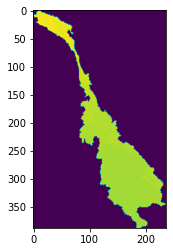

In [14]:
plt.imshow(elev)

In [15]:
x_res, y_res = r.res
lon_0, lat_0 = r.xy(0, 0)
lons1d = (np.arange(0, r.shape[1])*x_res + lon_0).round(5)
lats1d = (np.arange(0, r.shape[0])*-y_res + lat_0).round(5)

domain_ds = xr.Dataset(
    data_vars={
        "mask": (["lat", "lon"], mask),
        "elev": (["lat", "lon"], elev)
    },
    coords={
        "lat": (["lat"], lats1d),
        "lon": (["lon"], lons1d)
    }
)

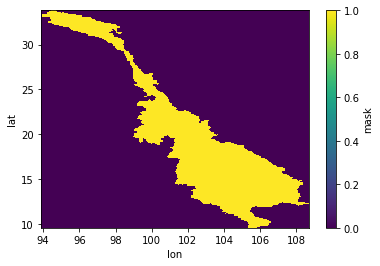

In [16]:
domain_ds.mask.plot()

In [17]:
domain_ds

domain_ds.mask.attrs['_FillValue'] = 0.0
domain_ds.elev.attrs['_FillValue'] = -32768.0

In [18]:
domain_ds.to_netcdf('../backend/params/metsim/domain.nc')

# Forcings

In [19]:
indir = "../backend/data/processed"

# p = rio.open(os.path.join(d, 'precipitation', '2001-01-01_IMERG.asc'))

In [23]:
# Making forcing files
dates = pd.date_range("2001-01-01", "2021-06-10")

precips = np.zeros((len(dates), len(domain_ds.lat), len(domain_ds.lon)))
tmaxes = np.zeros((len(dates), len(domain_ds.lat), len(domain_ds.lon)))
tmins = np.zeros((len(dates), len(domain_ds.lat), len(domain_ds.lon)))
winds = np.zeros((len(dates), len(domain_ds.lat), len(domain_ds.lon)))

with tqdm(total=len(dates)) as pbar:
    for i, d in enumerate(dates):
        pbar.set_description(f"{d.strftime('%Y-%m-%d')}")
        precip = rio.open(f"{indir}/precipitation/{d.strftime('%Y-%m-%d')}_IMERG.asc")
        precip_ar = precip.read(1)
        precip_ar[domain_ds.mask == 0] = -9999
        precips[i, :, :] = precip_ar
        #     print(precip_ar.shape)

        tmax = rio.open(f"{indir}/tmax/{d.strftime('%Y-%m-%d')}_TMAX.asc")
        tmax_ar = tmax.read(1)
        tmax_ar[domain_ds.mask == 0] = -9999
        tmaxes[i, :, :] = tmax_ar

        tmin = rio.open(f"{indir}/tmin/{d.strftime('%Y-%m-%d')}_TMIN.asc")
        tmin_ar = tmin.read(1)
        tmin_ar[domain_ds.mask == 0] = -9999
        tmins[i, :, :] = tmin_ar

        uwnd = rio.open(f"{indir}/uwnd/{d.strftime('%Y-%m-%d')}_UWND.asc")
        uwnd_ar = uwnd.read(1)

        vwnd = rio.open(f"{indir}/vwnd/{d.strftime('%Y-%m-%d')}_VWND.asc")
        vwnd_ar = vwnd.read(1)
        
        wind = 0.75 * np.sqrt(vwnd_ar**2 + uwnd_ar**2)
        wind[domain_ds.mask == 0] = -9999
        winds[i, :, :] = wind
        
        pbar.update(1)

    
# Add Temperature, Wind
forcings_ds = xr.Dataset(
    data_vars={
        "precip": (["time", "lat", "lon"], precips),
        "tmax": (["time", "lat", "lon"], tmaxes),
        "tmin": (["time", "lat", "lon"], tmins),
        "wind": (["time", "lat", "lon"], winds)
    },
    coords={
        "time": (["time"], dates),
        "lat": (["lat"], domain_ds.lat),
        "lon": (["lon"], domain_ds.lon)
    }
)
forcings_ds.precip.attrs['_FillValue'] = -9999
forcings_ds.tmax.attrs['_FillValue'] = -9999
forcings_ds.tmin.attrs['_FillValue'] = -9999
forcings_ds.wind.attrs['_FillValue'] = -9999

  0%|          | 0/7466 [00:00<?, ?it/s]

In [27]:
forcings_ds

<xarray.Dataset>
Dimensions:  (lat: 388, lon: 237, time: 7466)
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2021-06-10
  * lat      (lat) float64 33.78 33.72 33.66 33.59 ... 9.781 9.719 9.656 9.594
  * lon      (lon) float64 93.91 93.97 94.03 94.09 ... 108.5 108.5 108.6 108.7
Data variables:
    precip   (time, lat, lon) float64 -9.999e+03 -9.999e+03 ... -9.999e+03
    tmax     (time, lat, lon) float64 -9.999e+03 -9.999e+03 ... -9.999e+03
    tmin     (time, lat, lon) float64 -9.999e+03 -9.999e+03 ... -9.999e+03
    wind     (time, lat, lon) float64 -9.999e+03 -9.999e+03 ... -9.999e+03

In [28]:
forcings_ds.sel(time=slice('2001-01-01', '2001-03-31')).to_netcdf("../backend/params/metsim/state.nc")

In [29]:
rest_forcings = forcings_ds.sel(time=slice('2001-04-01', '2021-06-10'))
outpath = "../backend/data/metsim_inputs"

# years, datasets = zip(*rest_forcings.groupby('time.year'))
# paths = [os.path.join(outpath, f'forcing_{y}.nc') for y in years]

# xr.save_mfdataset(datasets, paths)

rest_forcings.to_netcdf(os.path.join(outpath, "forcings_all.nc"))